<a href="https://colab.research.google.com/github/Emmanuel461/PML_2023_2024/blob/main/Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[ 0.  0.  9. 16. 13.  1.  0.  0.  0.  8. 16.  8. 11.  8.  0.  0.  0. 11.
 10.  0.  8. 10.  0.  0.  0.  1.  5.  0. 11. 11.  0.  0.  0.  0.  0.  0.
 13.  9.  0.  0.  0.  0.  0.  4. 16.  2.  0.  0.  0.  0.  4. 14. 15.  7.
  4.  1.  0.  0.  8. 16. 16. 16. 16. 12.]
[[ 0.  0.  9. 16. 13.  1.  0.  0.]
 [ 0.  8. 16.  8. 11.  8.  0.  0.]
 [ 0. 11. 10.  0.  8. 10.  0.  0.]
 [ 0.  1.  5.  0. 11. 11.  0.  0.]
 [ 0.  0.  0.  0. 13.  9.  0.  0.]
 [ 0.  0.  0.  4. 16.  2.  0.  0.]
 [ 0.  0.  4. 14. 15.  7.  4.  1.]
 [ 0.  0.  8. 16. 16. 16. 16. 12.]]
2


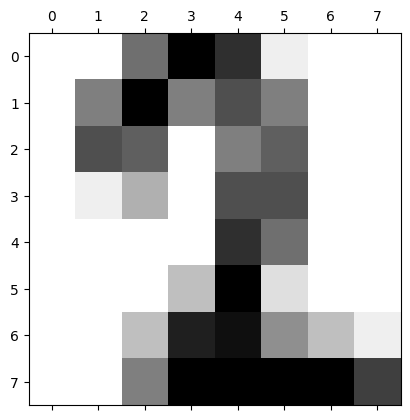

Epoch [100/300], Train Loss: 1.7137776613235474, Test Loss: 1.0171360969543457
Epoch [200/300], Train Loss: 1.1248419284820557, Test Loss: 0.5600990056991577
Epoch [300/300], Train Loss: 1.0295300483703613, Test Loss: 0.5242172479629517


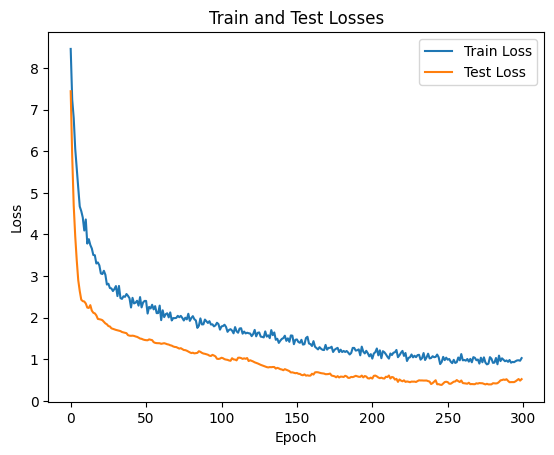

Accuracy on test set: 0.9083


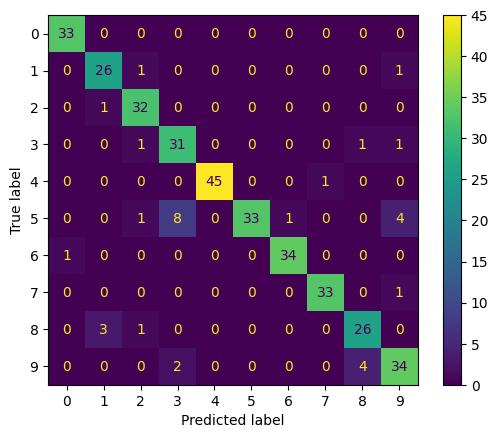

In [104]:
#@title This code is the adaptation to Tensorflow


import tensorflow as tf
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

CREATE_CLASS = True
SGD = False
IRIS = False
SHOW = True

# Load Iris dataset
if IRIS:
    examples = load_iris()
else:
    examples = load_digits()
    if SHOW:
        idx = np.random.randint(0, len(examples.target))
        print(examples.data[idx])
        print(examples.data[idx].reshape(8, 8))
        print(examples.target[idx])
        plt.matshow(examples.data[idx].reshape(8, 8), cmap=plt.cm.gray_r)
        plt.show()

X = examples.data
y = examples.target

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate the model
input_size = X_train.shape[1]
hidden_size = 16
output_size = len(examples.target_names)
batch_size=32
num_epochs = 300
# Optimizer specific options
learning_rate=0.001
regularization_param=0.1
momentum_param=0.9
# Dropout: if p>0
dropout_p=0.25 # During training, randomly zeroes some of the elements of the input tensor with probability p.

# Create TensorFlow dataset
train_dl = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(batch_size) # Cambio

########################################################### NN model
if CREATE_CLASS:
    class ThreeLayerNet(tf.keras.Model):
        def __init__(self, input_size, hidden_size, output_size):
            super(ThreeLayerNet, self).__init__()
            self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(regularization_param)) # Cambio
            self.dropout1 = tf.keras.layers.Dropout(dropout_p)
            self.fc2 = tf.keras.layers.Dense(hidden_size, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(regularization_param))
            self.dropout2 = tf.keras.layers.Dropout(dropout_p)
            self.fc3 = tf.keras.layers.Dense(output_size)
            self.dropout = tf.keras.layers.Dropout(dropout_p)  # Dropout layer with dropout probability
        def call(self, x):
            x = self.fc1(x)
            x = self.dropout1(x)
            x = self.fc2(x)
            x = self.dropout2(x)
            x = self.fc3(x)
            return x

    model = ThreeLayerNet(input_size, hidden_size, output_size)
else:
    # Or, in alternative, use Sequential
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_size, activation='relu', input_shape=(input_size,),kernel_regularizer=tf.keras.regularizers.L2(regularization_param)),
        tf.keras.layers.Dropout(dropout_p),
        tf.keras.layers.Dense(hidden_size, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(regularization_param)),
        tf.keras.layers.Dropout(dropout_p),
        tf.keras.layers.Dense(output_size)
    ])

####################################################################################################
# Define loss function and optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
if SGD:
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=momentum_param)
else:
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)



# Lists to store train and test losses
train_losses = []
test_losses = []

# Training the model
for epoch in range(num_epochs):
    train_loss = tf.keras.metrics.Mean() # CAMBIO el LOSS de keras no acepta 0
    for x_batch, y_batch in train_dl:
        with tf.GradientTape() as tape:
            pred = model(x_batch, training=True)
            loss = criterion(y_batch, pred)

        gradients = tape.gradient(loss, model.trainable_variables) ### CAMBIO
        optimizer.apply_gradients(zip(gradients, model.trainable_variables)) ##CAMBIO

        train_loss(loss)

    train_losses.append(train_loss.result())

    # Test the model
    pred_test = model(X_test, training=False)
    test_loss = criterion(y_test, pred_test)
    test_losses.append(test_loss)

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.result()}, Test Loss: {test_loss}')



# Plotting train and test losses
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()

# Testing the model
y_pred = np.argmax(model(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy:.4f}')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot()
plt.show()

